# Simple Model for Inference
This notebook will prepare the data and train a simple model that will be used for inference. A simple linear regression with Lasso penalization is used to create a model that is explainable.

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from joblib import dump
import seaborn as sns
import pandas as pd

In [2]:
train = pd.read_csv('../datasets/train_clean.csv')
test = pd.read_csv('../datasets/test_clean.csv')

## Preparing the data for model training
Strategy: Limit selection of columns to use to predict 'SalePrice'. Limiting features can help the model from overfitting, as well as make inference on unknown data points simplified (since less data is required).

In [3]:
# Using only the top 14 most correlated columns to predict 'SalePrice'
cols_to_predict = list(abs(train.corr()['SalePrice']).sort_values(ascending=False)[:16].index)
cols_to_predict

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'ExterQual',
 'KitchenQual',
 'GarageCars',
 'GarageArea',
 'BsmtQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'GarageFinish',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'YearBuilt',
 'YearRemodAdd']

In [4]:
# limiting the train and test datasets to the columns used to predict
train = train[cols_to_predict]
cols_to_predict.remove('SalePrice')
ids = test['Id']
test = test[cols_to_predict]

In [5]:
# looking at the first few rows for the train dataset
train.head()

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,BsmtQual,TotalBsmtSF,1stFlrSF,FullBath,GarageFinish,TotRmsAbvGrd,FireplaceQu,YearBuilt,YearRemodAdd
0,208500,7,1710,4,4,2,548,4,856,856,2,2,8,1,2003,2003
1,181500,6,1262,3,3,2,460,4,1262,1262,2,2,6,3,1976,1976
2,223500,7,1786,4,4,2,608,4,920,920,2,2,6,3,2001,2002
3,140000,7,1717,3,4,3,642,3,756,961,1,1,7,4,1915,1970
4,250000,8,2198,4,4,3,836,4,1145,1145,2,2,9,3,2000,2000


In [10]:
# defining the X and y datasets from the train data
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

In [11]:
# train-validation splitting the data using a random seed for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

In [12]:
# use standard scale to standardize data (and later help explainability)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
test = ss.transform(test)

In [13]:
X_train = pd.DataFrame(X_train, columns = X.columns)
test = pd.DataFrame(test, columns=X.columns)

## Training the model
Strategy: Train the model using a simple linear regression. This allows for high explainability and simple inference.

In [14]:
# using Lasso regression to train the model
lin_reg = LinearRegression()

# find the general performance of Lasso regression with cross_val_score
print(f'Cross validation R2 score: {round(cross_val_score(lin_reg, X_train, y_train).mean(), 4)}')

Cross validation R2 score: 0.7512


_Cross validation R2 score is at 0.75, meaning that about 75% of the varaiation in the target can be explained by the model. Generally speaking, the closer the R2 score is to 1, the better._

In [15]:
# fitting the model
lin_reg.fit(X_train, y_train)

# scoring the model on the validation data
val_score = lin_reg.score(X_val, y_val)
print(f'Linear regression R2 on validation data: {round(val_score, 4)}')

Linear regression R2 on validation data: 0.8303


In [16]:
# ordering columns by the magnitude of the coefficients on the variables
for col, coef in sorted(zip(X_train.columns, lin_reg.coef_), key = lambda x: x[1], reverse=True):
    print(col, round(coef, 2))

GrLivArea 21392.81
OverallQual 18839.15
BsmtQual 9487.53
1stFlrSF 9284.45
KitchenQual 9205.78
FireplaceQu 5371.14
GarageCars 5317.74
GarageArea 4967.41
ExterQual 4502.97
TotalBsmtSF 2313.13
YearBuilt 2279.74
GarageFinish 1287.96
TotRmsAbvGrd 1269.56
YearRemodAdd 688.04
FullBath -1670.71


## Evaluation
Simple linear regression provides a strong baseline for model prediction. With a R2 score on the validation dataset of 0.83, as well as a cross-validation score with 5-folds of 0.75, the linear regression model should provide a good starting point for inference.

In [17]:
# getting the predictions from linear regression on the validation dataset to plot residuals
preds = lin_reg.predict(X_val)

In [18]:
# Looking at RMSE and MAE values to put into original units for expainability
rmse = mean_squared_error(y_val, preds) ** 0.5
mae = mean_absolute_error(y_val, preds)

In [19]:
print(f'Root Mean Squared Error: {round(rmse, 2)}')
print(f'Mean Absolute Error: {round(mae, 2)}')

Root Mean Squared Error: 30995.38
Mean Absolute Error: 21756.86


_The difference in the two metrics show that there are a few outlier situations that are impacting the model. RMSE is more receptive to outliers while MAE is more resistant to it. However, based on the RMSE, we can say that **on average the 'SalePrice' prediction of the linear regression model is about $31,000 off from the true 'SalePrice' value**._

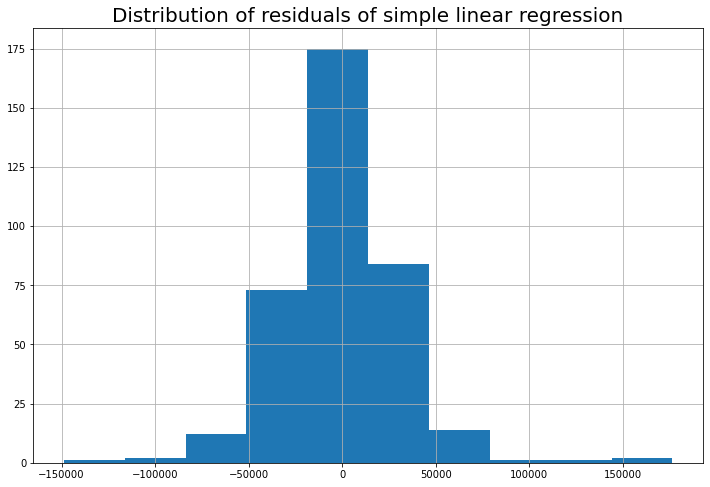

In [20]:
# Plotting residuals by finding prediction values minus true values
residuals = y_val - preds
plt.figure(figsize=(12,8))
plt.title('Distribution of residuals of simple linear regression', size=20)
residuals.hist()
plt.savefig('../images/simple_linear_distribution.png');

_Residuals plot is normal, as hoped. This shows that the model is performing decently._

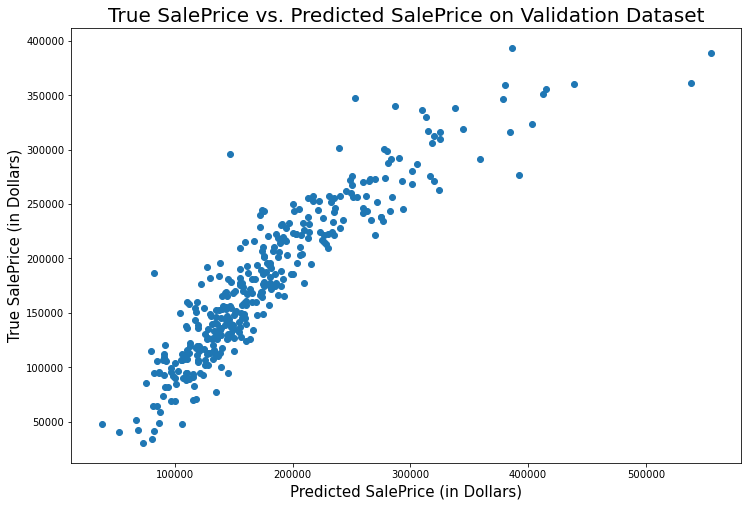

In [22]:
plt.figure(figsize=(12,8))
plt.title('True SalePrice vs. Predicted SalePrice on Validation Dataset', size=20)
plt.ylabel('True SalePrice (in Dollars)', fontsize=15)
plt.xlabel('Predicted SalePrice (in Dollars)', fontsize=15)
plt.scatter(y_val, preds)
plt.savefig('../images/simple_linear_residual.png')
plt.show();

_The residual plot shows a logarithmic-like curve. Perhaps later adding a logging function on the SalePrice would increase the performance of the model._

In [23]:
# saving standard scaler for inference
dump(ss, '../models/standard_scaler.joblib')

# saving model to use for inference
dump(lin_reg, '../models/linear_regression.joblib')

['../models/linear_regression.joblib']